# HR Analytics: Job Change Of Data Scientists
* 인공신경망 실습

# 데이터 설명(출처: Kaggle)

* city: City code

* city_ development _index : Developement index of the city (scaled)

* gender: Gender of candidate

* relevent_experience: Relevant experience of candidate

* enrolled_university: Type of University course enrolled if any

* education_level: Education level of candidate

* major_discipline :Education major discipline of candidate

* experience: Candidate total experience in years

* company_size: No of employees in current employer's company

* company_type : Type of current employer

* lastnewjob: Difference in years between previous job and current job

* training_hours: training hours completed

* target: 0 – Not looking for job change, 1 – Looking for a job change


데이터 사이언티스트들이 현재 새로운 직업을 찾고 있는지, 그렇지 않은지 분류하는 데이터 셋

In [ ]:
# 패키지 설치
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

from sklearn.model_selection import cross_val_score
from sklearn.metrics import roc_auc_score, roc_curve, precision_recall_curve, precision_score, recall_score, auc
from sklearn.metrics import confusion_matrix, plot_confusion_matrix
from sklearn.metrics import classification_report, accuracy_score, f1_score

In [ ]:
# 데이터 불러오기
train = pd.read_csv('/content/aug_train.csv')
train

,enrollee_id,city,city_development_index,gender,relevent_experience,enrolled_university,education_level,major_discipline,experience,company_size,company_type,last_new_job,training_hours,target
0,8949,city_103,0.920,Male,Has relevent experience,no_enrollment,Graduate,STEM,>20,NaN,NaN,1,36,1.0
1,29725,city_40,0.776,Male,No relevent experience,no_enrollment,Graduate,STEM,15,50-99,Pvt Ltd,>4,47,0.0
2,11561,city_21,0.624,NaN,No relevent experience,Full time course,Graduate,STEM,5,NaN,NaN,never,83,0.0
3,33241,city_115,0.789,NaN,No relevent experience,NaN,Graduate,Business Degree,<1,NaN,Pvt Ltd,never,52,1.0
4,666,city_162,0.767,Male,Has relevent experience,no_enrollment,Masters,STEM,>20,50-99,Funded Startup,4,8,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19153,7386,city_173,0.878,Male,No relevent experience,no_enrollment,Graduate,Humanities,14,NaN,NaN,1,42,1.0
19154,31398,city_103,0.920,Male,Has relevent experience,no_enrollment,Graduate,STEM,14,NaN,NaN,4,52,1.0
19155,24576,city_103,0.920,Male,Has relevent experience,no_enrollment,Graduate,STEM,>20,50-99,Pvt Ltd,4,44,0.0
19156,5756,city_65,0.802,Male,Has relevent experience,no_enrollment,High School,NaN,<1,500-999,Pvt Ltd,2,97,0.0


## EDA

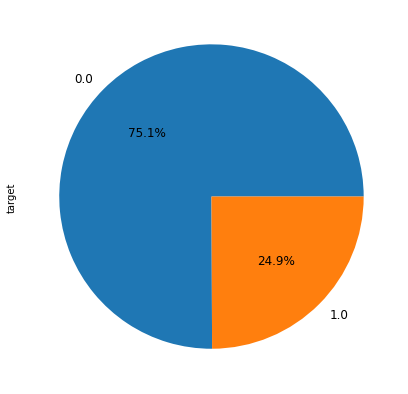

In [ ]:
f, ax = plt.subplots(figsize=(7, 7))
train['target'].value_counts().plot.pie(ax= ax, autopct='%1.1f%%',textprops={'fontsize': 12} )

* 타겟 값의 불균형 보임 -> 딥러닝에서는 데이터의 수가 많은 것이 더 성능이 좋으므로 oversampling 이용하기로 결정

In [ ]:
print(train.info())
print(train.isnull().sum())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19158 entries, 0 to 19157
Data columns (total 14 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   enrollee_id             19158 non-null  int64  
 1   city                    19158 non-null  object 
 2   city_development_index  19158 non-null  float64
 3   gender                  14650 non-null  object 
 4   relevent_experience     19158 non-null  object 
 5   enrolled_university     18772 non-null  object 
 6   education_level         18698 non-null  object 
 7   major_discipline        16345 non-null  object 
 8   experience              19093 non-null  object 
 9   company_size            13220 non-null  object 
 10  company_type            13018 non-null  object 
 11  last_new_job            18735 non-null  object 
 12  training_hours          19158 non-null  int64  
 13  target                  19158 non-null  float64
dtypes: float64(2), int64(2), object(10)
me

* 꽤 많은 결측값이 보여, 이를 채우기 위해 EDA를 진행해 봄

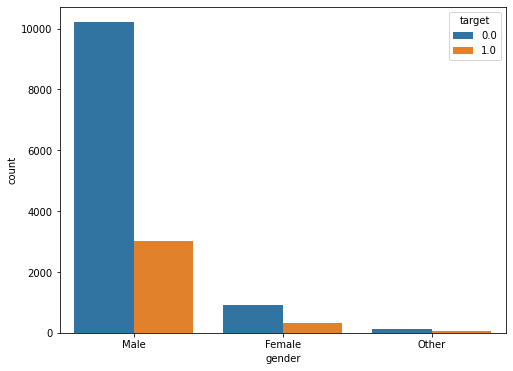

In [ ]:
plt.figure(figsize = (8,6))
sns.countplot(data = train, x = 'gender', hue = train['target'])

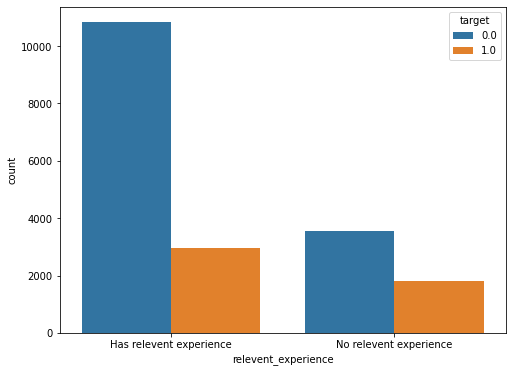

In [ ]:
plt.figure(figsize = (8,6))
sns.countplot(data = train, x = 'relevent_experience', hue = train['target'])

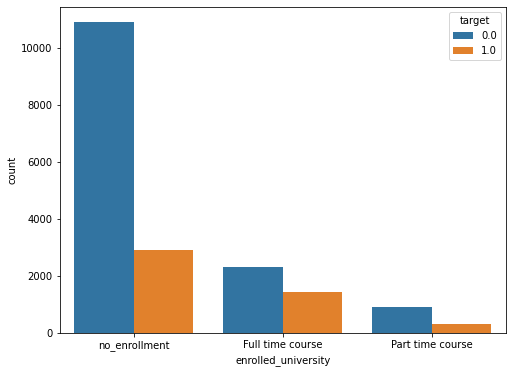

In [ ]:
plt.figure(figsize = (8,6))
sns.countplot(data = train, x = 'enrolled_university', hue = train['target'])

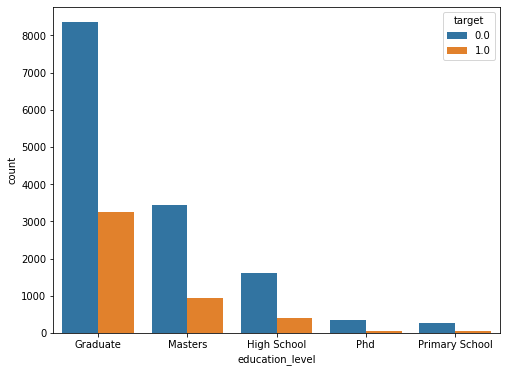

In [ ]:
plt.figure(figsize = (8,6))
sns.countplot(data = train, x = 'education_level', hue = train['target'])

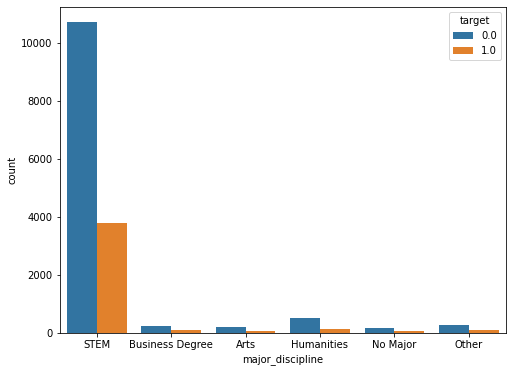

In [ ]:
plt.figure(figsize = (8,6))
sns.countplot(data = train, x = 'major_discipline', hue = train['target'])

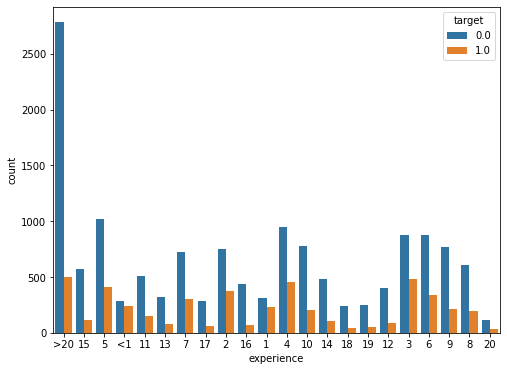

In [ ]:
plt.figure(figsize = (8,6))
sns.countplot(data = train, x = 'experience', hue = train['target'])

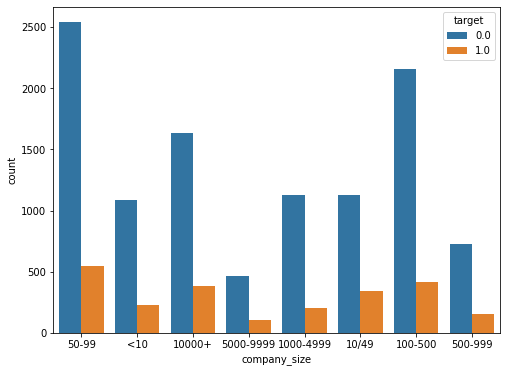

In [ ]:
plt.figure(figsize = (8,6))
sns.countplot(data = train, x = 'company_size', hue = train['target'])

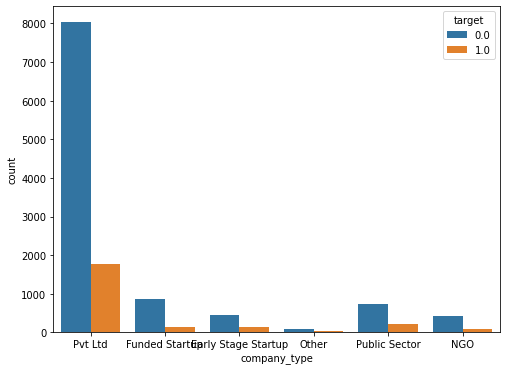

In [ ]:
plt.figure(figsize = (8,6))
sns.countplot(data = train, x = 'company_type', hue = train['target'])

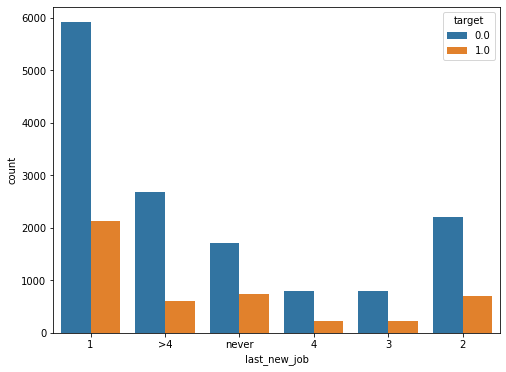

In [ ]:
plt.figure(figsize = (8,6))
sns.countplot(data = train, x = 'last_new_job', hue = train['target'])

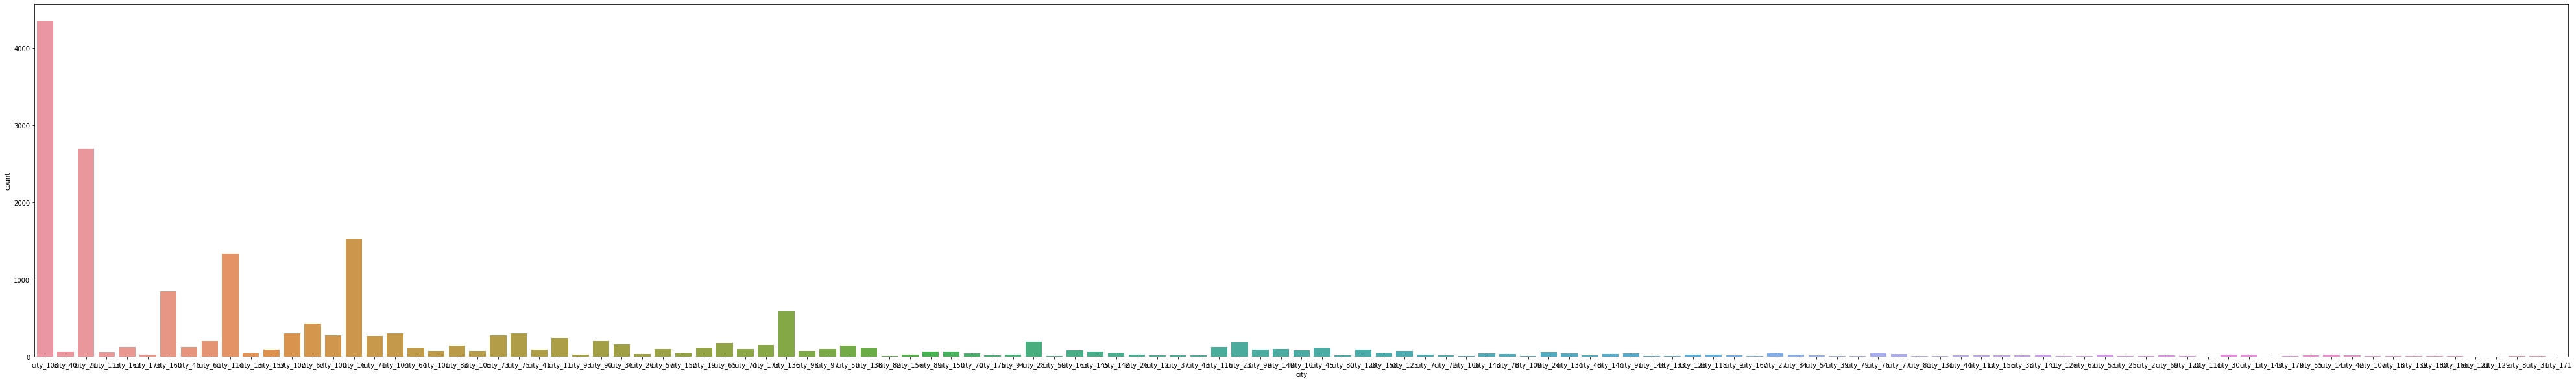

In [ ]:
plt.figure(figsize = (70,10))
sns.countplot(data = train, x = 'city')

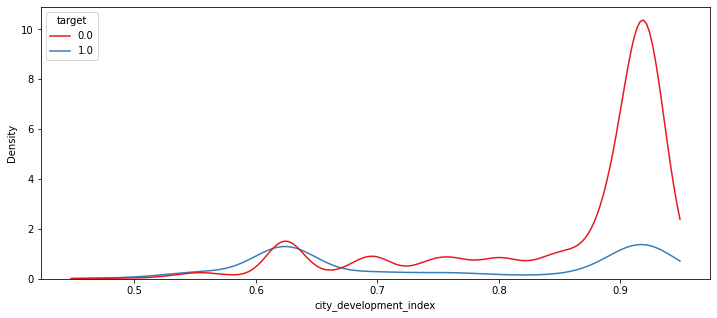

In [ ]:
plt.figure(figsize=(12, 5))
sns.kdeplot(data= train, x="city_development_index", hue="target",cut = 0,palette='Set1')

* developed cities에 사는 사람들이 직업을 바꿀 확률이 더 적다

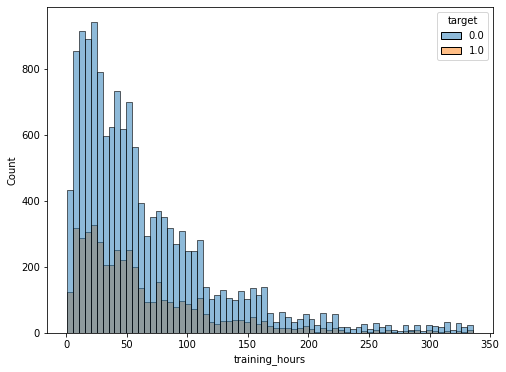

In [ ]:
plt.figure(figsize = (8,6))
sns.histplot(data = train, x = 'training_hours', hue = train['target'])

## 전처리

### 범위를 숫자로

In [ ]:
train['experience'].unique()

array(['>20', '15', '5', '<1', '11', '13', '7', '17', '2', '16', '1', '4',
       '10', '14', '18', '19', '12', '3', '6', '9', '8', '20', nan],
      dtype=object)

In [ ]:
def replace1(experience):
    if experience == '>20':
        return 21
    elif experience == '<1':
        return 0

    else:
        return experience

In [ ]:
train.experience = train.experience.map(replace1)
train['experience'].unique()

array([21, '15', '5', 0, '11', '13', '7', '17', '2', '16', '1', '4', '10',
       '14', '18', '19', '12', '3', '6', '9', '8', '20', nan],
      dtype=object)

In [ ]:
train['last_new_job'].unique()

array(['1', '>4', 'never', '4', '3', '2', nan], dtype=object)

In [ ]:
def replace2(last_new_job):
    if last_new_job == '>4':
        return 5
    elif last_new_job == 'never':
        return 0

    else:
        return last_new_job

In [ ]:
train.last_new_job = train.last_new_job.map(replace2)
train['last_new_job'].unique()

array(['1', 5, 0, '4', '3', '2', nan], dtype=object)

In [ ]:
train['company_size'].unique()

array([nan, '50-99', '<10', '10000+', '5000-9999', '1000-4999', '10/49',
       '100-500', '500-999'], dtype=object)

In [ ]:
def replace3(company_size):
    if company_size == '<10':
        return 9
    elif company_size == '10000+':
        return 10001
    elif company_size == '50-99':
        return 75
    elif company_size == '5000-9999':
        return 7500
    elif company_size == '10/49':
        return 25
    elif company_size == '1000-4999':
        return 25000
    elif company_size == '100-500':
        return 300
    elif company_size == '500-999':
        return 750

    else:
        return company_size

In [ ]:
train.company_size = train.company_size.map(replace3)
train['company_size'].unique()

array([       nan, 7.5000e+01, 9.0000e+00, 1.0001e+04, 7.5000e+03,
       2.5000e+04, 2.5000e+01, 3.0000e+02, 7.5000e+02])

### 분석에 필요 없는 칼럼 삭제

In [ ]:
train.drop(['enrollee_id', 'city'], axis = 1, inplace = True)

city는 범주가 너무 많아 분석 결과에 좋지 않은 영향을 끼칠 것이라고 판단

In [ ]:
train

,city_development_index,gender,relevent_experience,enrolled_university,education_level,major_discipline,experience,company_size,company_type,last_new_job,training_hours,target
0,0.920,Male,Has relevent experience,no_enrollment,Graduate,STEM,21,NaN,NaN,1,36,1.0
1,0.776,Male,No relevent experience,no_enrollment,Graduate,STEM,15,75.0,Pvt Ltd,5,47,0.0
2,0.624,NaN,No relevent experience,Full time course,Graduate,STEM,5,NaN,NaN,0,83,0.0
3,0.789,NaN,No relevent experience,NaN,Graduate,Business Degree,0,NaN,Pvt Ltd,0,52,1.0
4,0.767,Male,Has relevent experience,no_enrollment,Masters,STEM,21,75.0,Funded Startup,4,8,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...
19153,0.878,Male,No relevent experience,no_enrollment,Graduate,Humanities,14,NaN,NaN,1,42,1.0
19154,0.920,Male,Has relevent experience,no_enrollment,Graduate,STEM,14,NaN,NaN,4,52,1.0
19155,0.920,Male,Has relevent experience,no_enrollment,Graduate,STEM,21,75.0,Pvt Ltd,4,44,0.0
19156,0.802,Male,Has relevent experience,no_enrollment,High School,NaN,0,750.0,Pvt Ltd,2,97,0.0


### 결측 값 처리

* EDA를 바탕으로 가장 많게 나온 값으로 결측값을 대체했고, 
* Company_size 만 범주의 빈도가 비슷하여 평균값으로 대체

In [ ]:
train["gender"].fillna("Male", inplace = True)
train["enrolled_university"].fillna("no_enrollment", inplace = True)
train["education_level"].fillna("Graduate", inplace = True)
train["major_discipline"].fillna("STEM", inplace = True)
train["experience"].fillna("20", inplace = True)
train["company_size"].fillna(train["company_size"].mean(), inplace = True)
train["company_type"].fillna("Pvt Ltd", inplace = True)
train["last_new_job"].fillna("1", inplace = True)

In [ ]:
train

,city_development_index,gender,relevent_experience,enrolled_university,education_level,major_discipline,experience,company_size,company_type,last_new_job,training_hours,target
0,0.920,Male,Has relevent experience,no_enrollment,Graduate,STEM,21,4487.393419,Pvt Ltd,1,36,1.0
1,0.776,Male,No relevent experience,no_enrollment,Graduate,STEM,15,75.000000,Pvt Ltd,5,47,0.0
2,0.624,Male,No relevent experience,Full time course,Graduate,STEM,5,4487.393419,Pvt Ltd,0,83,0.0
3,0.789,Male,No relevent experience,no_enrollment,Graduate,Business Degree,0,4487.393419,Pvt Ltd,0,52,1.0
4,0.767,Male,Has relevent experience,no_enrollment,Masters,STEM,21,75.000000,Funded Startup,4,8,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...
19153,0.878,Male,No relevent experience,no_enrollment,Graduate,Humanities,14,4487.393419,Pvt Ltd,1,42,1.0
19154,0.920,Male,Has relevent experience,no_enrollment,Graduate,STEM,14,4487.393419,Pvt Ltd,4,52,1.0
19155,0.920,Male,Has relevent experience,no_enrollment,Graduate,STEM,21,75.000000,Pvt Ltd,4,44,0.0
19156,0.802,Male,Has relevent experience,no_enrollment,High School,STEM,0,750.000000,Pvt Ltd,2,97,0.0


In [ ]:
train.isnull().sum()

city_development_index    0
gender                    0
relevent_experience       0
enrolled_university       0
education_level           0
major_discipline          0
experience                0
company_size              0
company_type              0
last_new_job              0
training_hours            0
target                    0
dtype: int64

### 정규화

* 신경망 모델에서는 입력데이터의 서로 다른 피처 값의 범위를 비슷한 크기로 맞춰 주는 것이 유리하기 때문에 정규화 진행

In [ ]:
from sklearn.preprocessing import MinMaxScaler
train["training_hours"] = MinMaxScaler().fit_transform(np.array(train["training_hours"]).reshape(-1,1))

In [ ]:
train

,city_development_index,gender,relevent_experience,enrolled_university,education_level,major_discipline,experience,company_size,company_type,last_new_job,training_hours,target
0,0.920,Male,Has relevent experience,no_enrollment,Graduate,STEM,21,4487.393419,Pvt Ltd,1,0.104478,1.0
1,0.776,Male,No relevent experience,no_enrollment,Graduate,STEM,15,75.000000,Pvt Ltd,5,0.137313,0.0
2,0.624,Male,No relevent experience,Full time course,Graduate,STEM,5,4487.393419,Pvt Ltd,0,0.244776,0.0
3,0.789,Male,No relevent experience,no_enrollment,Graduate,Business Degree,0,4487.393419,Pvt Ltd,0,0.152239,1.0
4,0.767,Male,Has relevent experience,no_enrollment,Masters,STEM,21,75.000000,Funded Startup,4,0.020896,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...
19153,0.878,Male,No relevent experience,no_enrollment,Graduate,Humanities,14,4487.393419,Pvt Ltd,1,0.122388,1.0
19154,0.920,Male,Has relevent experience,no_enrollment,Graduate,STEM,14,4487.393419,Pvt Ltd,4,0.152239,1.0
19155,0.920,Male,Has relevent experience,no_enrollment,Graduate,STEM,21,75.000000,Pvt Ltd,4,0.128358,0.0
19156,0.802,Male,Has relevent experience,no_enrollment,High School,STEM,0,750.000000,Pvt Ltd,2,0.286567,0.0


### 인코딩

* 범주형 데이터는 원핫인코딩 진행

In [ ]:
from sklearn.preprocessing import LabelEncoder, StandardScaler

In [ ]:
numerical_feats = train.dtypes[train.dtypes != "object"].index.tolist()
numerical_feats.remove('target')
print("Number of Numerical features: ", len(numerical_feats))

categorical_feats = train.dtypes[train.dtypes == "object"].index.tolist()
print("Number of Categorical features: ", len(categorical_feats))

Number of Numerical features:  3
Number of Categorical features:  8


In [ ]:
numerical_feats

['city_development_index', 'company_size', 'training_hours']

In [ ]:
categorical_feats

['gender',
 'relevent_experience',
 'enrolled_university',
 'education_level',
 'major_discipline',
 'experience',
 'company_type',
 'last_new_job']

In [ ]:
train_one_hot = pd.get_dummies(train, columns = ['gender', 'relevent_experience', 'enrolled_university',
                                                 'education_level', 'major_discipline', 'experience', 'company_type', 'last_new_job'])
train.drop(['gender', 'relevent_experience', 'enrolled_university','education_level',
          'major_discipline', 'experience', 'company_type', 'last_new_job', 'target'],axis=1,inplace=True)
train = pd.concat([train ,train_one_hot],axis=1)

In [ ]:
train.dtypes

city_development_index                         float64
company_size                                   float64
training_hours                                 float64
city_development_index                         float64
company_size                                   float64
training_hours                                 float64
target                                         float64
gender_Female                                    uint8
gender_Male                                      uint8
gender_Other                                     uint8
relevent_experience_Has relevent experience      uint8
relevent_experience_No relevent experience       uint8
enrolled_university_Full time course             uint8
enrolled_university_Part time course             uint8
enrolled_university_no_enrollment                uint8
education_level_Graduate                         uint8
education_level_High School                      uint8
education_level_Masters                          uint8
education_

### 불균형 처리

* Oversampling 방법 중 Smote , adasyn 두 가지 불균형 방법 시도

In [ ]:
X = train.drop(['target'], axis=1)
y = train['target']

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
from imblearn.over_sampling import SMOTE
from collections import Counter

counter = Counter(y_train)
print('Before',counter)

smt = SMOTE()
X_train_sm, y_train_sm = smt.fit_resample(X_train, y_train)
X_val_sm, y_val_sm = smt.fit_resample(X_val, y_val)

counter = Counter(y_train_sm)
print('After',counter)

/usr/local/lib/python3.7/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


Before Counter({0.0: 11501, 1.0: 3825})
After Counter({1.0: 11501, 0.0: 11501})


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


In [ ]:
from imblearn.over_sampling import ADASYN

counter = Counter(y_train)
print('Before',counter)

ada = ADASYN(random_state=130)
X_train_ada, y_train_ada = ada.fit_resample(X_train, y_train)
X_val_ada, y_val_ada = ada.fit_resample(X_val, y_val)

counter = Counter(y_train_ada)
print('After',counter)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


Before Counter({0.0: 11501, 1.0: 3825})


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


After Counter({1.0: 11644, 0.0: 11501})


## 모델링

In [ ]:
from keras.models import Sequential
from keras.layers import Dense
import keras

### 불균형 처리 전 모델링

* 임의로 3개의 은닉층을 쌓고 각 유닛은 보편적으로 사용한다는 128, 64, 32, 와 같이 구성했고, 출력증이에는 이중분류이기 때문에 2개의 유닛과 시그모이드 활성화 함수를 적용
* 모델이 훈련하는데에 필요한 옵티마이저와 손실함수를 compli함수에 지정하고 정확도를 보기 위해 metrics옵션에 평가지표 정확도를 추가

In [ ]:
model1 = keras.Sequential([keras.layers.Flatten(input_shape =(59,)),
                keras.layers.Dense(128,activation = 'sigmoid'),    
                keras.layers.Dense(64,activation = 'sigmoid'),    
                keras.layers.Dense(32,activation = 'sigmoid'),   
                keras.layers.Dense(2,activation = 'sigmoid')])
model1.compile(optimizer = 'sgd',loss='sparse_categorical_crossentropy',metrics =['accuracy'])

In [ ]:
model1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 59)                0         
                                                                 
 dense (Dense)               (None, 128)               7680      
                                                                 
 dense_1 (Dense)             (None, 64)                8256      
                                                                 
 dense_2 (Dense)             (None, 32)                2080      
                                                                 
 dense_3 (Dense)             (None, 2)                 66        
                                                                 
Total params: 18,082
Trainable params: 18,082
Non-trainable params: 0
_________________________________________________________________


* 신경망 모델 구성한 결과

epochs 200, batch_size 30, steps_per_epoch 30으로 설정하고 모델 학습

In [ ]:
history1 = model1.fit(X_train, y_train,epochs =200,batch_size=30,steps_per_epoch=30)

Epoch 1/200
30/30 [==============================] - 0s 2ms/step - loss: 0.5903 - accuracy: 0.7233
Epoch 2/200
30/30 [==============================] - 0s 1ms/step - loss: 0.5671 - accuracy: 0.7467
Epoch 3/200
30/30 [==============================] - 0s 2ms/step - loss: 0.5858 - accuracy: 0.7278
Epoch 4/200
30/30 [==============================] - 0s 2ms/step - loss: 0.5476 - accuracy: 0.7644
Epoch 5/200
30/30 [==============================] - 0s 2ms/step - loss: 0.5752 - accuracy: 0.7389
Epoch 6/200
30/30 [==============================] - 0s 1ms/step - loss: 0.5609 - accuracy: 0.7522
Epoch 7/200
30/30 [==============================] - 0s 2ms/step - loss: 0.5610 - accuracy: 0.7522
Epoch 8/200
30/30 [==============================] - 0s 2ms/step - loss: 0.5469 - accuracy: 0.7644
Epoch 9/200
30/30 [==============================] - 0s 2ms/step - loss: 0.5491 - accuracy: 0.7622
Epoch 10/200
30/30 [==============================] - 0s 2ms/step - loss: 0.5674 - accuracy: 0.7467
Epoch 11/

In [ ]:
model1.evaluate(X_val, y_val)

120/120 [==============================] - 0s 1ms/step - loss: 0.5608 - accuracy: 0.7516


[0.5607597231864929, 0.7515657544136047]

* 정확도: 0.7516

epoch수가 증가할때의 손실함수와 정확도의 그래프

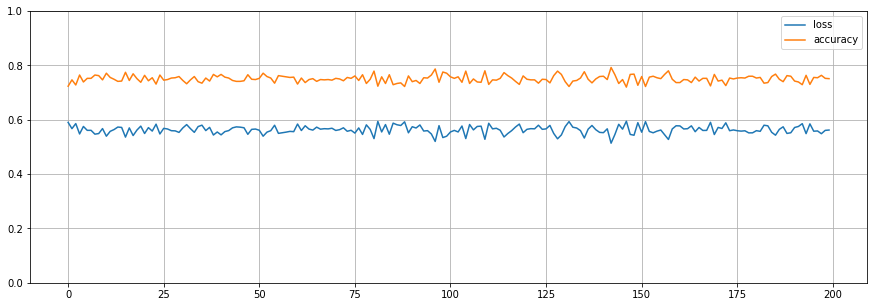

In [ ]:
pd.DataFrame(history1.history).plot(figsize = (15, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1)
plt.show()

In [ ]:
X_new = X_val[:]
y_proba = model1.predict(X_new)
y_proba.round(2)

array([[0.7 , 0.44],
       [0.7 , 0.44],
       [0.7 , 0.44],
       ...,
       [0.71, 0.45],
       [0.7 , 0.44],
       [0.7 , 0.44]], dtype=float32)

불균형 처리를 하지 않아, 정확도는 0.7 몇 이지만 거의 0으로 예측을 해버려서 불균형 처리 진행

### 불균형 처리 후 모델링

In [ ]:
history4 = model1.fit(X_train_sm, y_train_sm ,epochs = 50,batch_size=30,steps_per_epoch=400)

Epoch 1/50
400/400 [==============================] - 1s 2ms/step - loss: 0.6973 - accuracy: 0.4957
Epoch 2/50
400/400 [==============================] - 1s 2ms/step - loss: 0.6942 - accuracy: 0.4952
Epoch 3/50
400/400 [==============================] - 1s 2ms/step - loss: 0.6939 - accuracy: 0.4966
Epoch 4/50
400/400 [==============================] - 1s 2ms/step - loss: 0.6939 - accuracy: 0.4978
Epoch 5/50
400/400 [==============================] - 1s 2ms/step - loss: 0.6936 - accuracy: 0.5080
Epoch 6/50
400/400 [==============================] - 1s 2ms/step - loss: 0.6935 - accuracy: 0.5046
Epoch 7/50
400/400 [==============================] - 1s 2ms/step - loss: 0.6936 - accuracy: 0.5033
Epoch 8/50
400/400 [==============================] - 1s 2ms/step - loss: 0.6937 - accuracy: 0.5023
Epoch 9/50
400/400 [==============================] - 1s 2ms/step - loss: 0.6937 - accuracy: 0.5017
Epoch 10/50
400/400 [==============================] - 1s 2ms/step - loss: 0.6937 - accuracy: 0.5004

In [ ]:
model1.evaluate(X_val_sm, y_val_sm)

180/180 [==============================] - 0s 2ms/step - loss: 0.6936 - accuracy: 0.5000


[0.6936371326446533, 0.5]

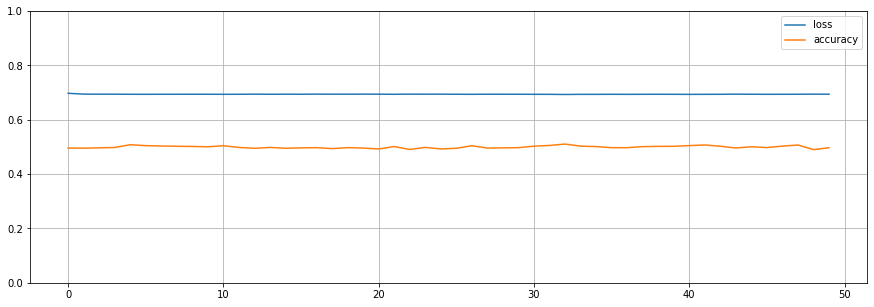

In [ ]:
pd.DataFrame(history4.history).plot(figsize = (15, 5))    
plt.grid(True)
plt.gca().set_ylim(0, 1)
plt.show()

In [ ]:
X_new = X_val_sm[:]
y_proba = model1.predict(X_new)
y_proba.round(2)

array([[0.58, 0.57],
       [0.58, 0.57],
       [0.58, 0.57],
       ...,
       [0.58, 0.57],
       [0.58, 0.57],
       [0.58, 0.57]], dtype=float32)

In [ ]:
history5 = model1.fit(X_train_ada, y_train_ada ,epochs = 50,batch_size=30,steps_per_epoch=400)

Epoch 1/50
400/400 [==============================] - 1s 2ms/step - loss: 0.6935 - accuracy: 0.5089
Epoch 2/50
400/400 [==============================] - 1s 2ms/step - loss: 0.6933 - accuracy: 0.5051
Epoch 3/50
400/400 [==============================] - 1s 2ms/step - loss: 0.6936 - accuracy: 0.5046
Epoch 4/50
400/400 [==============================] - 1s 2ms/step - loss: 0.6936 - accuracy: 0.4984
Epoch 5/50
400/400 [==============================] - 1s 2ms/step - loss: 0.6938 - accuracy: 0.4963
Epoch 6/50
400/400 [==============================] - 1s 2ms/step - loss: 0.6937 - accuracy: 0.5009
Epoch 7/50
400/400 [==============================] - 1s 2ms/step - loss: 0.6937 - accuracy: 0.5037
Epoch 8/50
400/400 [==============================] - 1s 2ms/step - loss: 0.6937 - accuracy: 0.4975
Epoch 9/50
400/400 [==============================] - 1s 2ms/step - loss: 0.6940 - accuracy: 0.4921
Epoch 10/50
400/400 [==============================] - 1s 2ms/step - loss: 0.6937 - accuracy: 0.4965

In [ ]:
model1.evaluate(X_val_ada, y_val_ada)

182/182 [==============================] - 0s 2ms/step - loss: 0.6935 - accuracy: 0.5050


[0.6934756636619568, 0.5049845576286316]

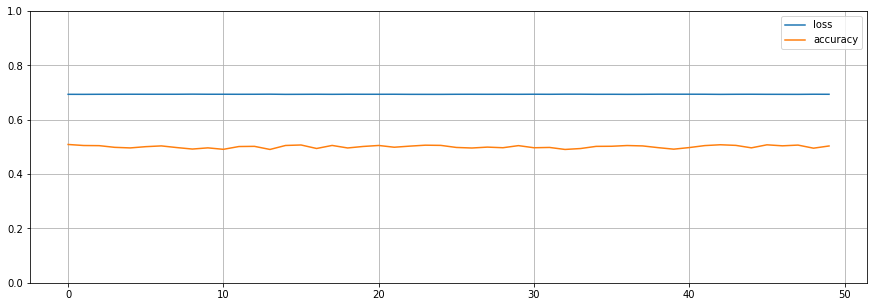

In [ ]:
pd.DataFrame(history5.history).plot(figsize = (15, 5))    
plt.grid(True)
plt.gca().set_ylim(0, 1)
plt.show()

In [ ]:
X_new = X_val_ada[:]
y_proba = model1.predict(X_new)
y_proba.round(2)

array([[0.58, 0.6 ],
       [0.58, 0.6 ],
       [0.58, 0.6 ],
       ...,
       [0.58, 0.6 ],
       [0.57, 0.6 ],
       [0.58, 0.6 ]], dtype=float32)

성능이 좋지 못해 개선하는 방법으로 딥러닝 하이퍼파라미터인 활성화 함수를 다른 값으로 바꿔보며 진행

In [ ]:
model6 = keras.Sequential([keras.layers.Flatten(input_shape =(59,1)),
                keras.layers.Dense(40,activation = 'relu'),    
                keras.layers.Dense(30,activation = 'relu'),    
                keras.layers.Dense(20,activation = 'relu'),   
                keras.layers.Dense(2,activation = 'sigmoid')])
model6.compile(optimizer = 'sgd',loss='sparse_categorical_crossentropy',metrics =['accuracy'])

print(model6.summary())

history6 = model6.fit(X_train_sm, y_train_sm ,epochs = 100,batch_size=32,steps_per_epoch=470)

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_1 (Flatten)         (None, 59)                0         
                                                                 
 dense_4 (Dense)             (None, 40)                2400      
                                                                 
 dense_5 (Dense)             (None, 30)                1230      
                                                                 
 dense_6 (Dense)             (None, 20)                620       
                                                                 
 dense_7 (Dense)             (None, 2)                 42        
                                                                 
Total params: 4,292
Trainable params: 4,292
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/100
470/470 [==========================

In [ ]:
model6.evaluate(X_val_sm, y_val_sm)

180/180 [==============================] - 0s 1ms/step - loss: 0.6932 - accuracy: 0.5000


[0.6932317018508911, 0.5]

In [ ]:
# 층 쌓기
model7 = keras.Sequential([keras.layers.Flatten(input_shape =(59,1)),
                keras.layers.Dense(40,activation = 'relu'),    
                keras.layers.Dense(20,activation = 'relu'),    
                keras.layers.Dense(10,activation = 'relu'),   
                keras.layers.Dense(2,activation = 'sigmoid')])
model7.compile(optimizer = 'sgd',loss='sparse_categorical_crossentropy',metrics =['accuracy'])

print(model7.summary())

history7 = model7.fit(X_train_sm, y_train_sm ,epochs = 100,batch_size=32,steps_per_epoch=470)


Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_2 (Flatten)         (None, 59)                0         
                                                                 
 dense_8 (Dense)             (None, 40)                2400      
                                                                 
 dense_9 (Dense)             (None, 20)                820       
                                                                 
 dense_10 (Dense)            (None, 10)                210       
                                                                 
 dense_11 (Dense)            (None, 2)                 22        
                                                                 
Total params: 3,452
Trainable params: 3,452
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/100
470/470 [==========================

In [ ]:
model7.evaluate(X_val_sm, y_val_sm)

180/180 [==============================] - 0s 1ms/step - loss: 0.6931 - accuracy: 0.5000


[0.6931473016738892, 0.5]

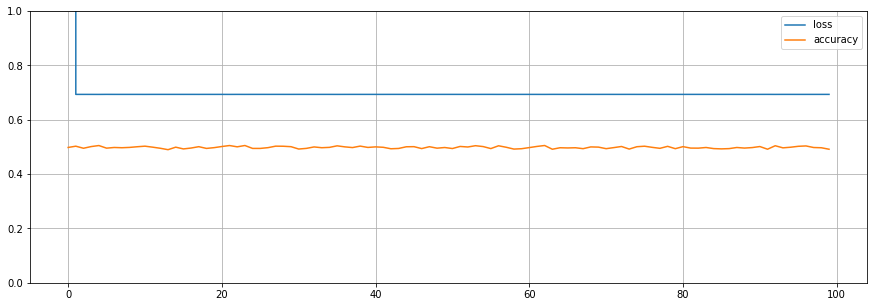

In [ ]:
# 그래프
pd.DataFrame(history7.history).plot(figsize = (15, 5))    
plt.grid(True)
plt.gca().set_ylim(0, 1)
plt.show()